# Проект: Линейные модели в машинном обучении


**Цель работы**: разработать модель машинного обучения, которая поможет  управлять рисками и принимать объективное решение о покупке коров по конкретным критериям

**План работы**: <a id="plan"></a>
1. [Загрузка данных](#shag1)
2. [Предобработка данных](#shag2)
3. [Исследовательский анализ данных](#shag3)
4. [Корреляционный анализ](#shag4)
5. [Обучение модели линейной регрессии](#shag5)
6. [Обучение модели логистической регрессии](#shag6)
7. [Общий вывод](#shag7)

## Информация о данных

**Файл ferma_main.csv содержит данные о стаде фермера на текущий момент.**

Описание данных:

    id — уникальный идентификатор коровы.
    Удой, кг — масса молока, которую корова даёт в год (в килограммах).
    ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
    Сырой протеин, г — содержание сырого протеина в корме (в граммах).
    СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
    Порода — порода коровы.
    Тип пастбища — ландшафт лугов, на которых паслась корова.
    порода папы_быка — порода папы коровы.
    Жирность,% — содержание жиров в молоке (в процентах).
    Белок,% — содержание белков в молоке (в процентах).
    Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
    
**Признаки в датасете ferma_main.csv можно разделить на группы.**

    Характеристики коровы: id, Порода, порода папы_быка, Возраст.
    Характеристики корма: ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение).
    Характеристика пастбища: Тип пастбища.
    Характеристики молока: Удой, кг, Жирность,%, Белок,%, Вкус молока.

**Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера.**

Описание данных:

    id — уникальный идентификатор коровы.
    Имя Папы — имя папы коровы.
    Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
    Порода — порода коровы.
    Тип пастбища — ландшафт лугов, на которых паслась корова.
    порода папы_быка — порода папы коровы.
    Имя_папы — имя папы коровы.
    Текущая_жирность,% — содержание жиров в молоке (в процентах).
    Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
    Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
    
**Данные в файлах ferma_main.csv и cow_buy.csv похожи, но у датасета cow_buy.csv несколько особенностей.**

    Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
    Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют.
    Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих             параметров на 5%.
    Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать.

In [1]:
import pandas as pd
import numpy as np

import math
from math import sqrt

from scipy import stats as st
from scipy.stats import binom, norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

<a id="shag1"></a> 
## Загрузка данных

In [2]:
ferma_main_data = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad_data = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy_data = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [3]:
ferma_main_data.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [4]:
ferma_main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Сопоставляя таблицу и её характеристику, видно соответсвие между типами данных столбца и его значениями

In [5]:
ferma_main_data.duplicated().sum()

5

В данных было обнаружено 5 дубликатов. Разберёмся с ними в процессе предобработки данных

In [6]:
# эта функция рисует графики распределения значений количественных признаков
# с указанием названия графика и признака
def start_distribution(data, titles, xlabels, figsize):
    
    axes = data[xlabels].hist(figsize=figsize).ravel()
    for i in range(len(axes)): 
        #print(i)
        axes[i].set_title(titles[i])
        axes[i].set_ylabel('Частота')
        axes[i].set_xlabel(xlabels[i])
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show();

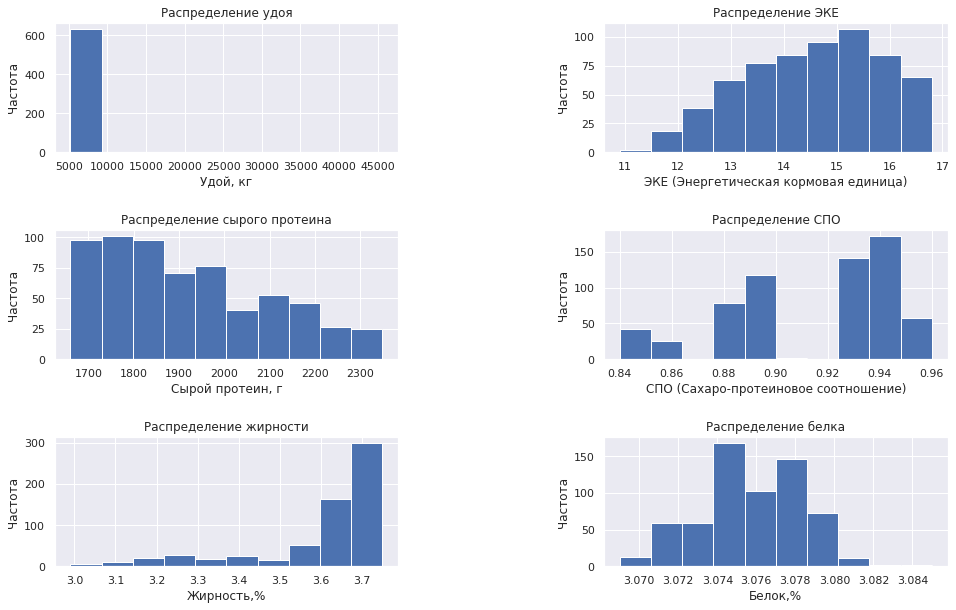

In [7]:
ferma_main_title = ['Распределение удоя',
                    'Распределение ЭКЕ',
                    'Распределение сырого протеина',
                    'Распределение СПО',
                    'Распределение жирности',
                    'Распределение белка'
                   ]
ferma_main_xlabel = ['Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
                     'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)',
                     'Жирность,%', 'Белок,%'
                    ]

start_distribution(ferma_main_data, ferma_main_title, ferma_main_xlabel, (16, 10))

По графику видно, что в стобцах *Удой, кг*, *Белок,%* присутствуют аномальные значения

В таблице **ferma_main_data**:
- отсутствуют пропущенные значения,
- присутствуют явные дубликаты,
- стобцах *Удой, кг*, *Белок,%* присутствуют аномальные значения,
- типы столбцов не соответсвуют данным

In [8]:
ferma_dad_data

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


Названия столбцов некорректны

In [9]:
ferma_dad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Типы данных столбцов соответсвуют наполнению

In [10]:
ferma_dad_data.duplicated().sum()

0

В таблице **ferma_dad_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- отсутствуют явные дубликаты

In [11]:
cow_buy_data

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


В таблице всего 20 строк данных

Названия столбцов также записаны некоррекно

In [12]:
cow_buy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Пропуски отсутствуют

In [13]:
cow_buy_data.duplicated().sum()

4

Из 20 строк данных целых 4 являются дубликатами

В таблице **cow_buy_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- присутствуют явные дубликаты

**В результате загрузки и общего изучения данных:**

- были скачаны таблицы: **ferma_main_data**, **ferma_dad_data**, **cow_buy_data**

В таблице **ferma_main_data**:
- отсутствуют пропущенные значения,
- присутствуют явные дубликаты,
- стобцах *Удой, кг*, *Белок,%* присутствуют аномальные значения,
- типы столбцов не соответсвуют данным

В таблице **ferma_dad_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- отсутствуют явные дубликаты

В таблице **cow_buy_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- присутствуют явные дубликаты

<a id="shag2"></a> 
##  Предобработка данных

### Изменение названия столбцов

Приведём названия к нижнему регистру и уберём ненужные символы

In [14]:
ferma_main_data.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [15]:
ferma_main_data.columns = ['идентификатор_коровы', 'удой', 'энергетическая_кормовая_единица',
                           'сырой_протеин', 'сахаро_протеиновое_соотношение',
                           'порода', 'тип_пастбища', 'порода_папы_быка', 'жирность', 'белок',
                           'вкус_молока', 'возраст'
                          ]

In [16]:
ferma_dad_data.columns

Index(['id', 'Имя Папы'], dtype='object')

In [17]:
ferma_dad_data.columns = ['идентификатор_коровы', 'имя_папы']

In [18]:
cow_buy_data.columns

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

In [19]:
cow_buy_data.columns = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'жирность', 'белок', 'возраст']

### Обработка дубликатов

Cначала избавимся от явных дубликатов в таблицах

In [20]:
ferma_main_data.drop_duplicates(inplace=True)
ferma_main_data.duplicated().sum()

0

In [21]:
cow_buy_data.drop_duplicates(inplace=True)
cow_buy_data.duplicated().sum()

0

Займёмся обработкой неявных дубликатов

In [22]:
ferma_main_data['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [23]:
cow_buy_data['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [24]:
cow_buy_data['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [25]:
ferma_main_data['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

*Равнинное* и *равнинные* - одинаковые значения; заменим *Равнинные* на *Равнинное*. Кроме того, для соответствия значений в таблице **ferma_main_data** и **cow_buy_data** значения в **ferma_main_data** следует привести к нижнемну регистру

In [26]:
ferma_main_data['тип_пастбища'].replace(
    {'Равнинные': 'равнинное', 'Холмистое': 'холмистое', 'Равнинное': 'равнинное'},
    inplace=True)

In [27]:
ferma_main_data['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [28]:
cow_buy_data['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

В таблице **ferma_main_data** порода быка может принимать как значение *Айдиал*, так и *Айдиалл*, которые по своей сути говорят нам об одной и той же породе, так что следует выбрать только один тип написания. Так, в таблице **cow_buy_data** породы *Айдиалл* нет, так что заменим *Айдиалл* на *Айдиал* в **ferma_main_data**

In [29]:
ferma_main_data['порода_папы_быка'].replace({'Айдиалл': 'Айдиал'}, inplace=True)

In [30]:
ferma_main_data['вкус_молока'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [31]:
ferma_main_data['возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Проверим, появились ли дубликаты

In [32]:
ferma_main_data.duplicated().sum()

0

In [33]:
cow_buy_data.duplicated().sum()

0

Дубликатов в данных не оказалось

// нужно ли производить изменение типов данных строковых столбцов на числовые здесь или лучше потом? Для дальнейшего анализа данных и их корреляций было бы удобнее, если некоторые строковые переменные стали категориальными числовыми

**В результате предобработки данных были:**

- изменены названия столбцов на таблиц **ferma_main_data, ferma_dad_data, cow_buy_data** на корректные,
- установлено отсутствие неявных дубликатов во всех трёх таблицах

<a id="shag3"></a> 
## Исследовательский анализ данных

### Статистический анализ признаков

In [34]:
ferma_main_data.describe()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,жирность,белок
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Средний объём удоя превышает порог заказчика, так что задача кажется выполнимой

// Нужно ли вообще сравнивать значения таблиц? Ведь разница между количеством данных слишком велика

In [35]:
cow_buy_data.describe()

,жирность,белок
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Показатели белка и жирности в таблицах схожи

### Графическое представление признаков

In [36]:
ferma_main_data.head()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


Разделим количественные и категориальные признаки

In [37]:
ferma_num_cols = ferma_main_data.select_dtypes(exclude='object').columns
ferma_obj_cols = ferma_main_data.select_dtypes(include='object').columns

Изучим распределение данных в количественных признаках

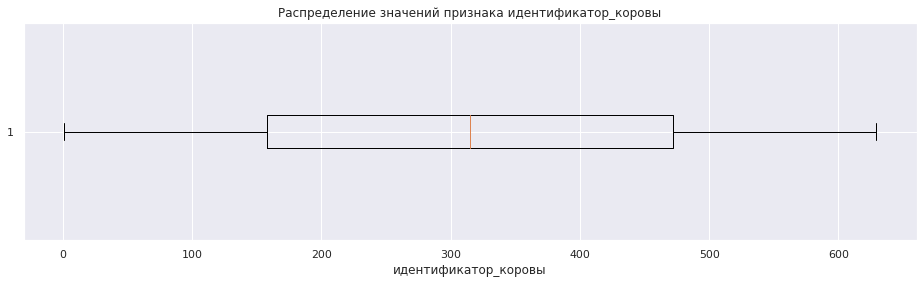

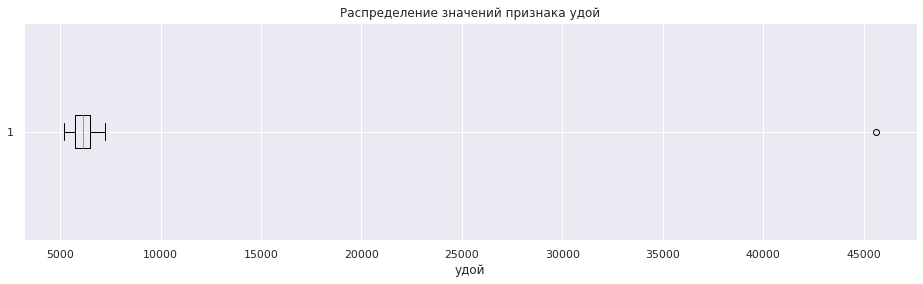

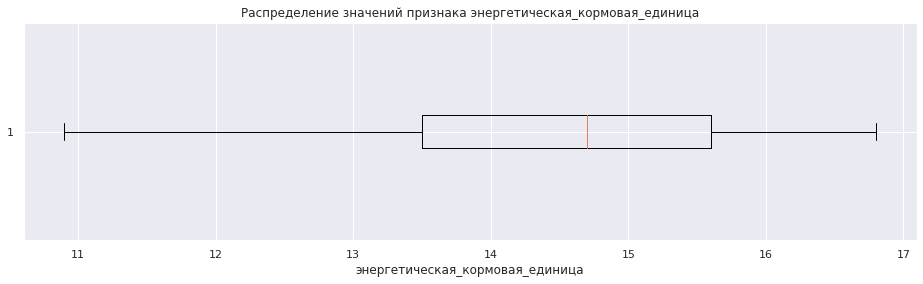

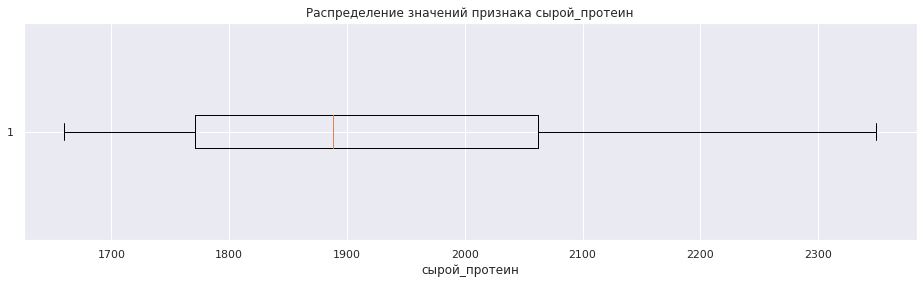

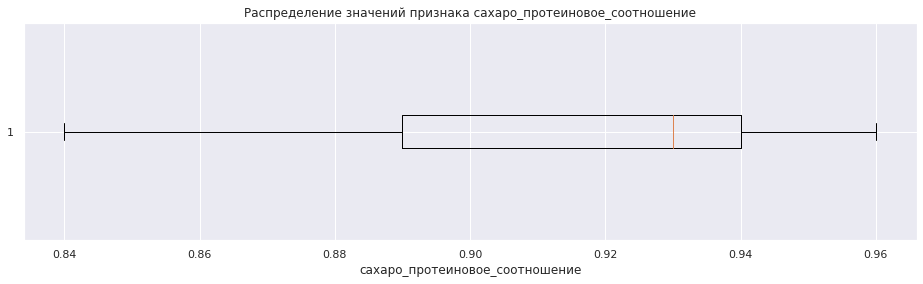

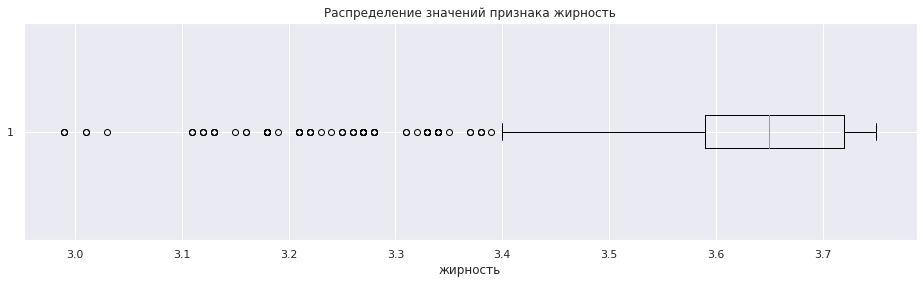

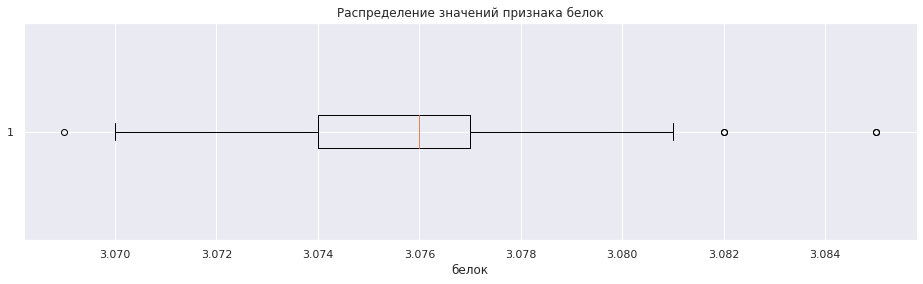

In [38]:
for column in ferma_num_cols:
    plt.figure(figsize=(16,4))
    
    plt.boxplot(ferma_main_data[column], vert=False)
    
    plt.title(f'Распределение значений признака {column}')
    plt.xlabel(column)
    plt.show();

По графику распределения удоя явно заметно аномальное значение(удой превышет 45000). Наверняка это ошибка была вызвана человеческим фактором(человек ошибся с измерениями на 0), однако значение 4500 также будет аномальным для таблицы, так что просто удалим эту запись.

Аномальные значения также присутствуют и в других столбцах, однако они не являются столь выраженными, так что не думаю, что они сильно повлияют на исследование

In [39]:
ferma_main_data = ferma_main_data[ferma_main_data['удой'] < 10000]

Теперь изучим частоту появления того или иного значения в количественных признаках

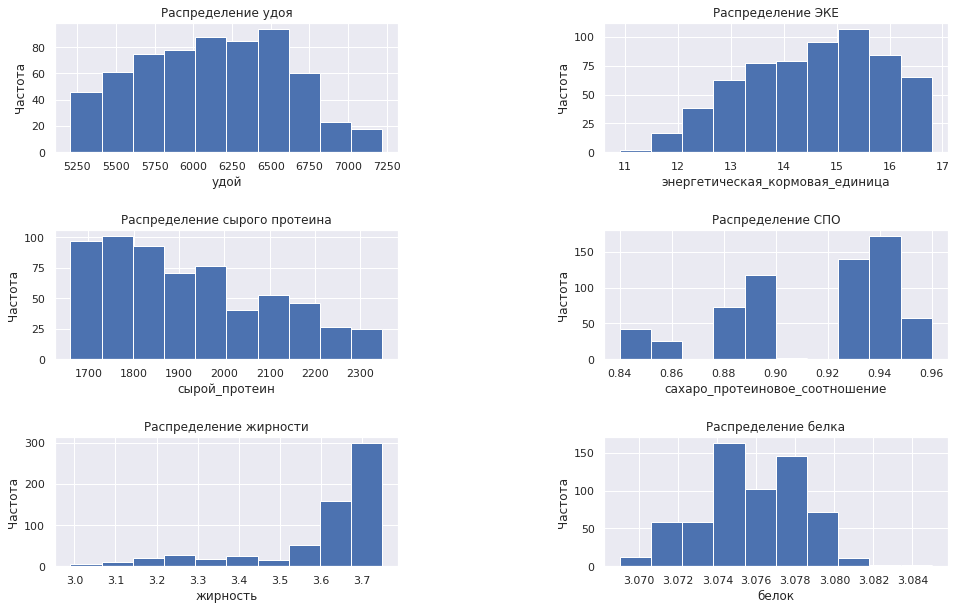

In [40]:
start_distribution(ferma_main_data[ferma_num_cols.drop('идентификатор_коровы')],
                   ferma_main_title,
                   ferma_num_cols.drop('идентификатор_коровы'),
                   (16, 10))

По графикам можно заметить странное распределение значений в столбцах *сахаро_протеиновое_соотношение* и *белок*

In [41]:
ferma_main_data[ferma_main_data['сахаро_протеиновое_соотношение'].isin([0.87, 0.91, 0.92])]

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст


Так, почему-то нет коров с СПО равным 0.87, 0.91, 0.92

Изучим распределение данных в категориальных признаках

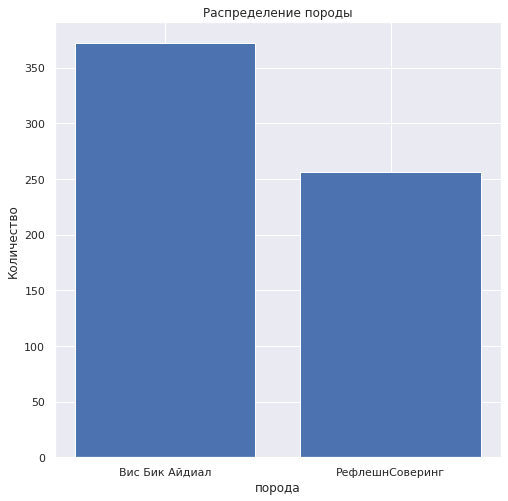

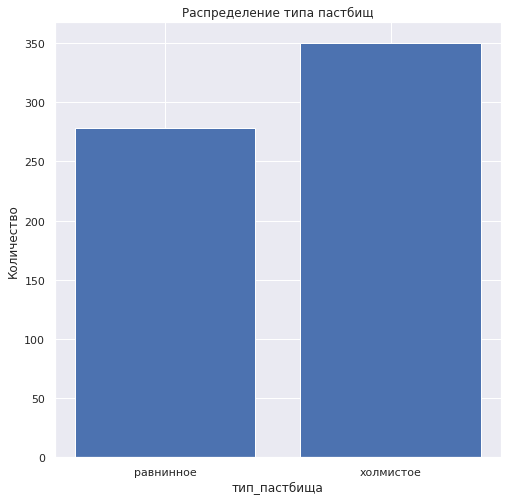

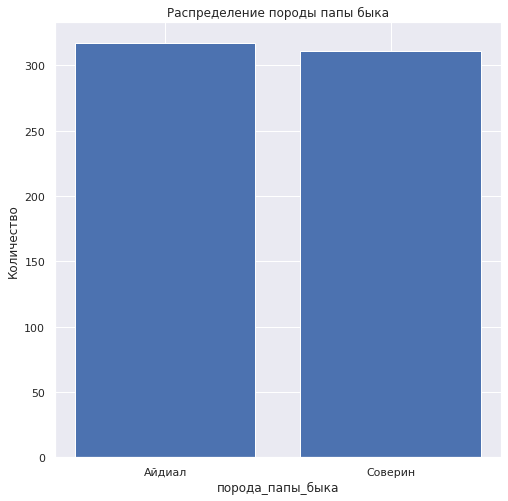

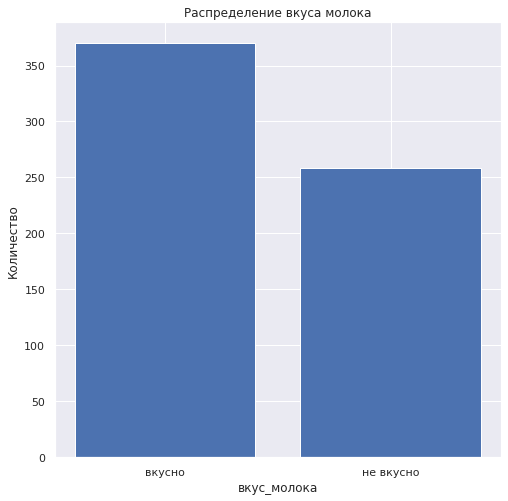

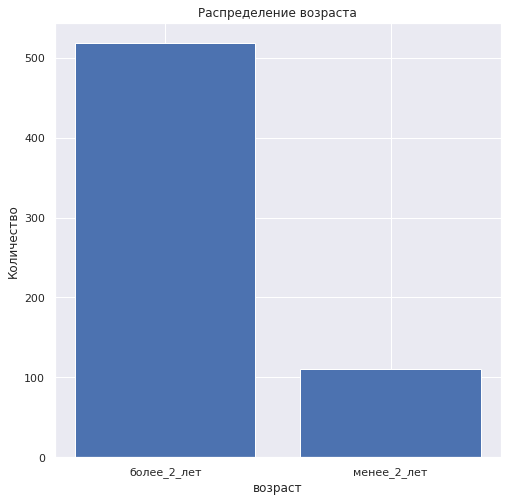

In [42]:
obj_titles = ['породы', 'типа пастбищ', 'породы папы быка', 'вкуса молока', 'возраста']

for i in range(len(ferma_obj_cols)):
    plt.figure(figsize=(8, 8))
    
    obj_data_count = ferma_main_data.groupby(ferma_obj_cols[i])[ferma_obj_cols[i]].count()

    plt.bar(obj_data_count.index, obj_data_count)
    
    plt.title(f'Распределение {obj_titles[i]}')
    plt.xlabel(ferma_obj_cols[i])
    plt.ylabel('Количество')
    plt.show();

По данным графикам можно сделать выводы, что:

- коров *Вис Бик Айдиал* больше, чем РефлешнСоверинг,
- в холмистой местности посётся немного больше коров, чем на равнинах,
- породы папы быка распределены равномерно,
- большинство коров даёт вкусное молоко,
- коров, чей возраст превышает 2 года значительно больше, чем коров младше двух лет

В дальнейшем, в целях МО, следует:

- нормализовать количественные переменные,
- преобразовать категориальные переменные

**В ходе исследовательского анализа данных:**

- количественные показатели коров фермера и коров «ЭкоФермы» совпадают,
- были устранены некоторые аномальные значения в количественных параметрах,
- было обнаружено, что большинство коров приносит надой, болший, чем требует заказчик(6000)
- было замечено распределение, далёкое от нормального в столбцах *сахаро_протеиновое_соотношение*(которое связано с отсутствием промежуточных значений) и *белок*(установить причину не удалось)
- коров *Вис Бик Айдиал* больше, чем РефлешнСоверинг,
- в холмистой местности посётся немного больше коров, чем на равнинах,
- породы папы быка распределены равномерно,
- большинство коров даёт вкусное молоко,
- коров, чей возраст превышает 2 года значительно больше, чем коров младше двух лет

<a id="shag4"></a> 
## Корреляционный анализ

In [43]:
ferma_main_data.head()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


Измененим типы данных признака *вкус_молока* на числовой для анализа зависимостей

In [44]:
# преобразование строковых значений вкусно, не вкусно в 1 и 0 соответственно
ferma_main_data['вкус_молока'] = ferma_main_data['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

### Изучим зависимость переменных друг от друга

<a id="heatmap"></a> 
Воспользуемся heatmap для того, чтобы посмотреть, как одни значения зависят от других

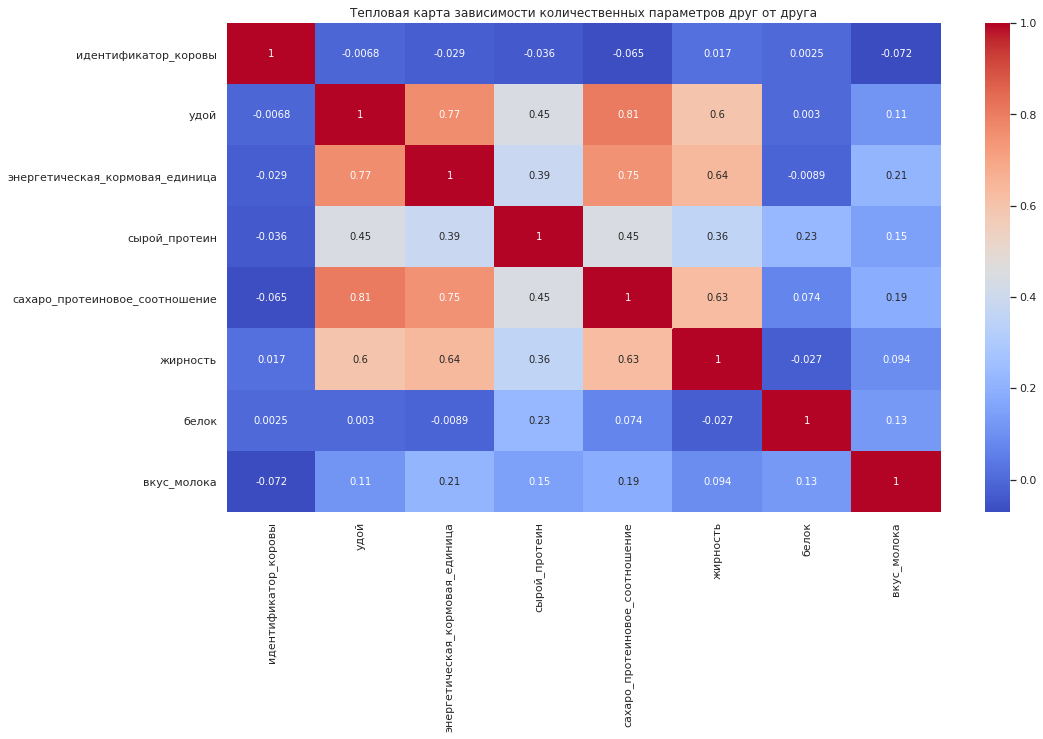

In [45]:
plt.figure(figsize=(16, 9))
sns.heatmap(ferma_main_data.corr(), annot=True, cmap='coolwarm')
plt.title('Тепловая карта зависимости количественных параметров друг от друга')
plt.show();

По графику видно, что на больше всего интересующую нас количественную переменную *Удой* больше всего влияют *энергетическая_кормовая_единица* и *сахаро_протеиновое_соотношение* (их корреляция с удоем превышает 0.7(является высокой))
Кроме того, на объём удоя влияют *жирность*(средняя корреляция 0.6) и *сырой_протеин*(слабая корреляция 0.45)

### Изучение влияния параметров на объём Удоя

<a id="corrs"></a> 
Сначала изучим зависимость целевой переменной от входных признаков

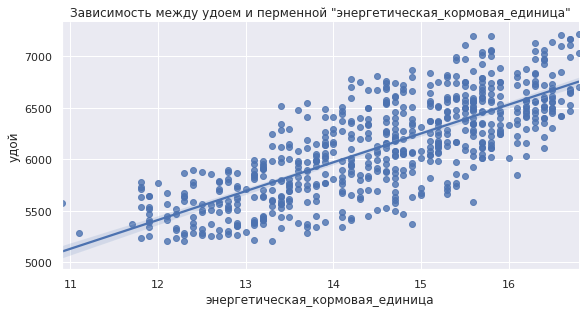

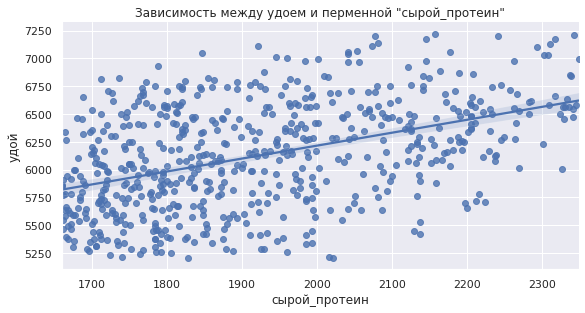

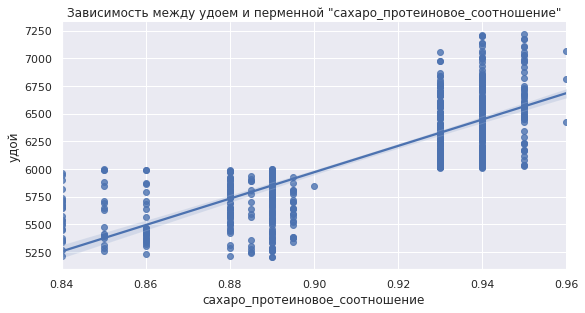

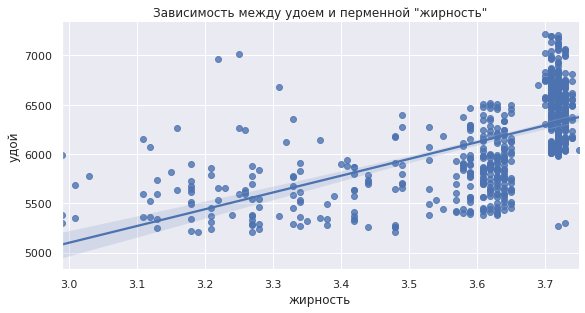

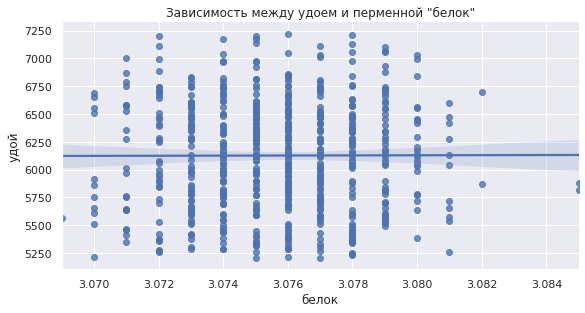

In [46]:
for num_col in ferma_num_cols.drop(['идентификатор_коровы', 'удой']):
    sns.lmplot(data=ferma_main_data, x=num_col, y='удой', height=4, aspect=2)
    plt.title(f'Зависимость между удоем и перменной "{num_col}"')
    plt.show();

По этим графикам можно сделать вывод о видах зависимости между удоем и другими количественными признаками:

Зависимость между удоем и переменной

- *энергетическая_кормовая_единица* линейна,
- *сырой_протеин* линейна,
- *сахаро_протеиновое_соотношение* нелинейна: так, на графике видно три кластера данных, по одному из которых можно однозначно определить, будет ли удой коровы больше 6000(при СПО больше 0.92),
- *жирность* нелинейна: есть два явно выраженных кластера и некоторое количество значений, разбросанных случайно. Кроме того, по одному из класеров, так же, как и по *сахаро_протеиновое_соотношение* можно узнать, даст ли корова удоя на 6000 и более или нет.
- *белок* нелинейна: распределение переменных и их значений напоминает распределение Пуассона. Так, в центре графика находится большее количество значений, чем по его краям.

Посмотрим, как разные категориальные переменные влияют на корреляцию удоя и качаественных переменных

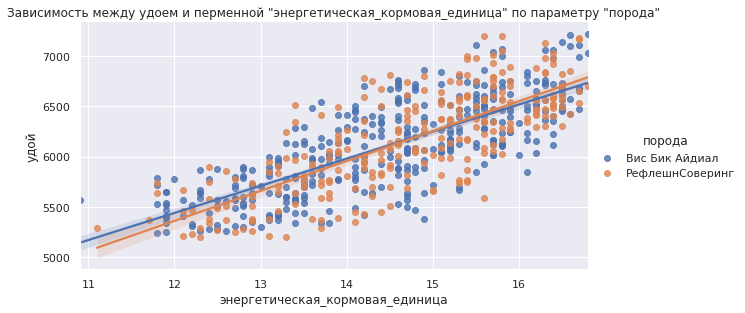

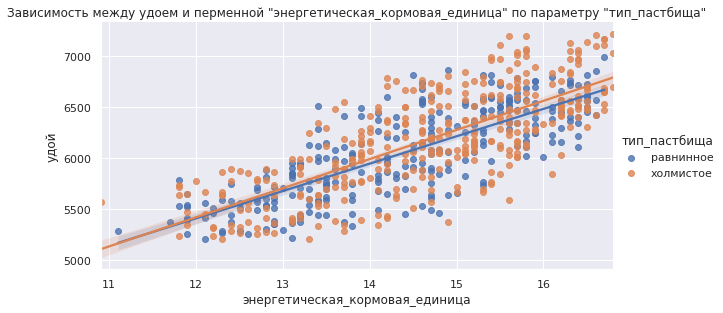

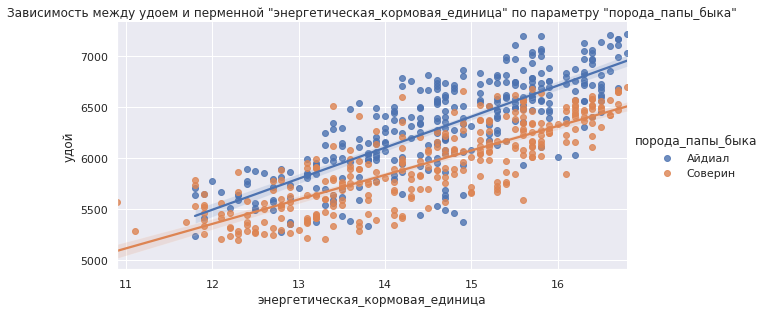

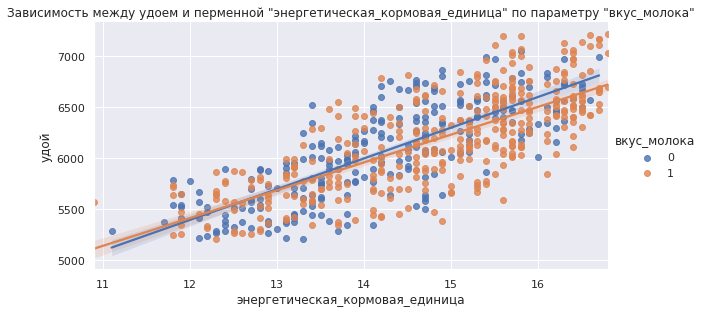

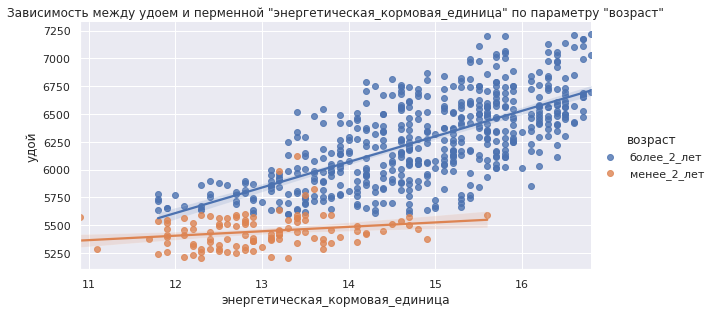

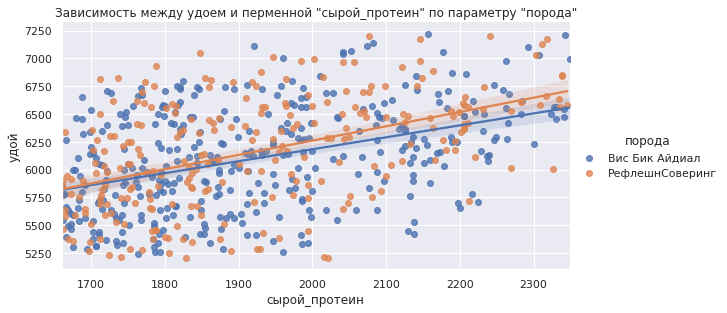

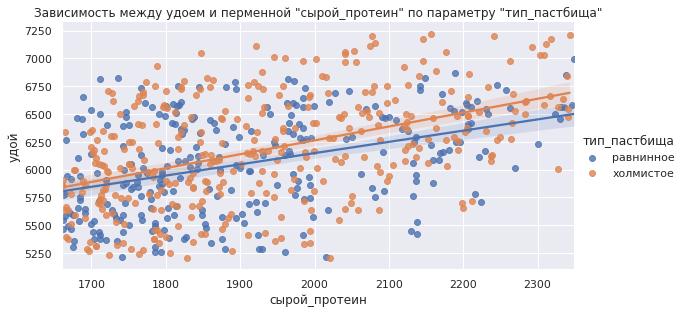

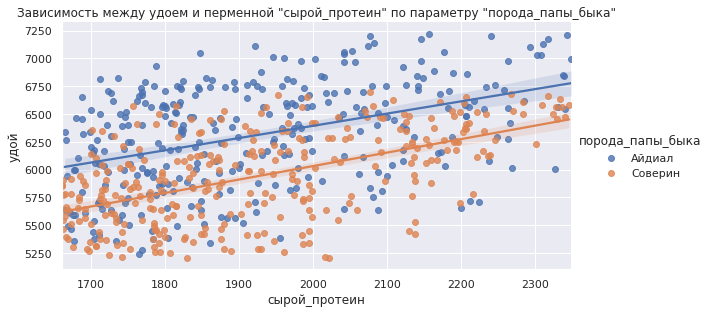

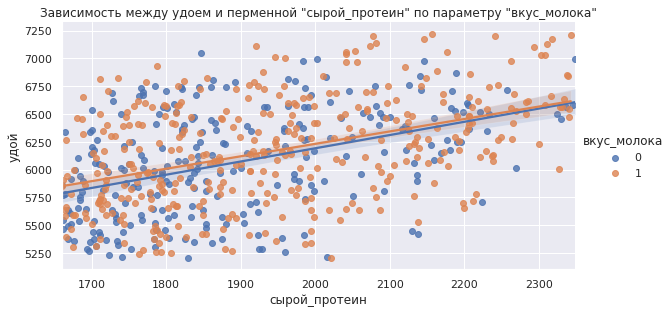

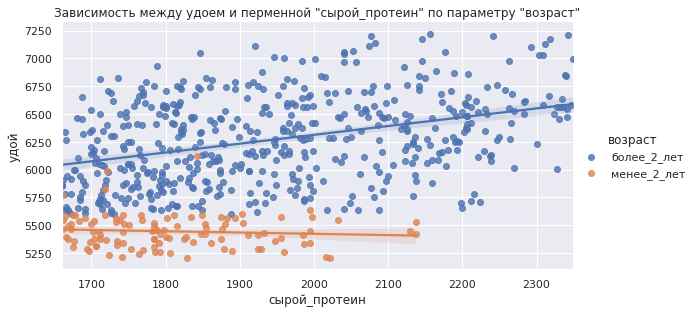

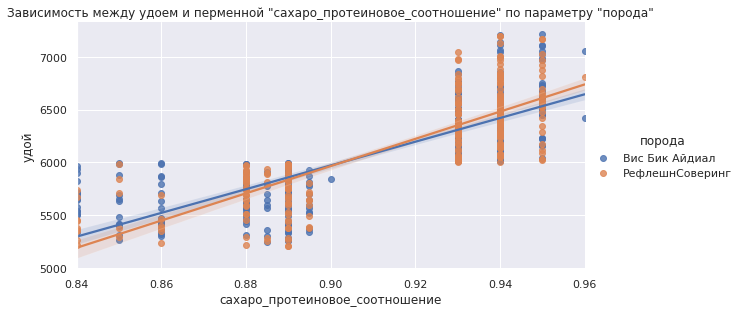

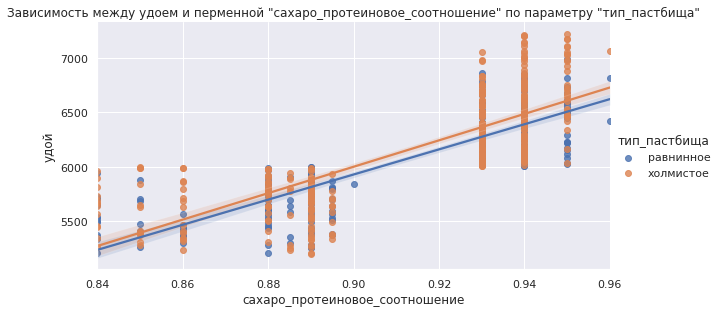

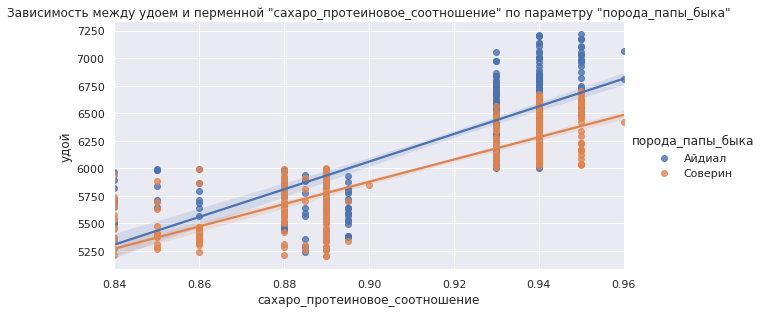

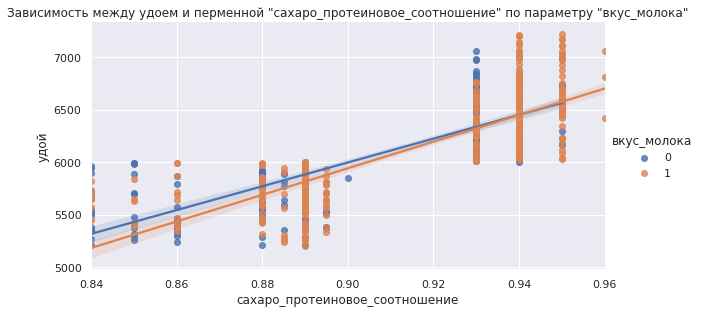

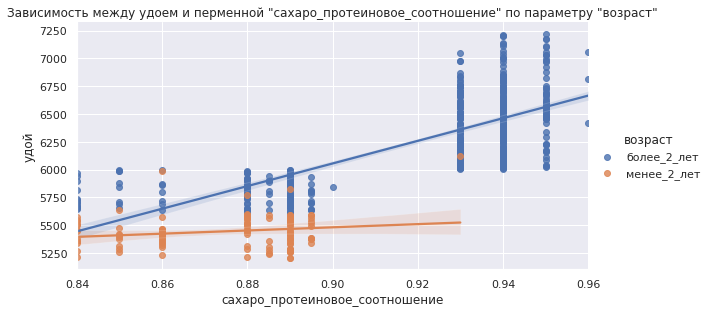

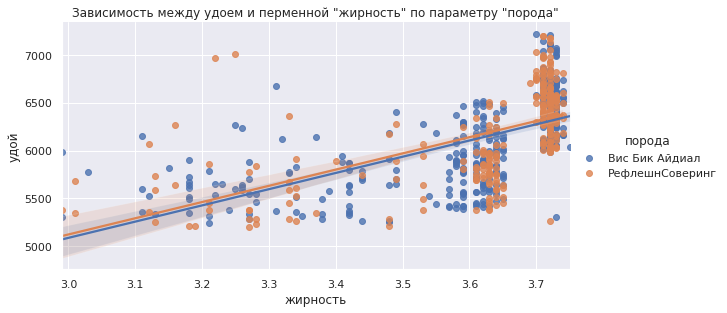

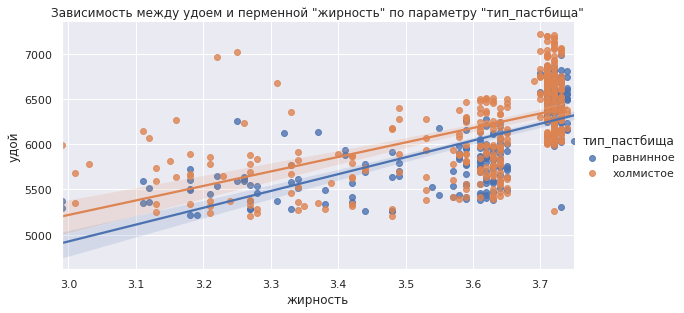

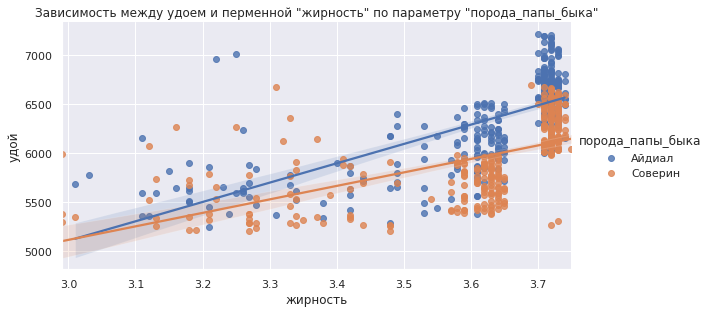

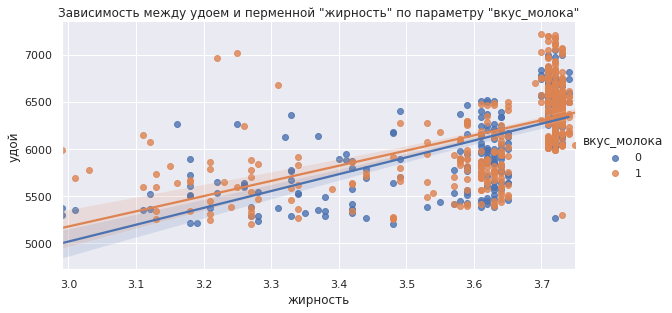

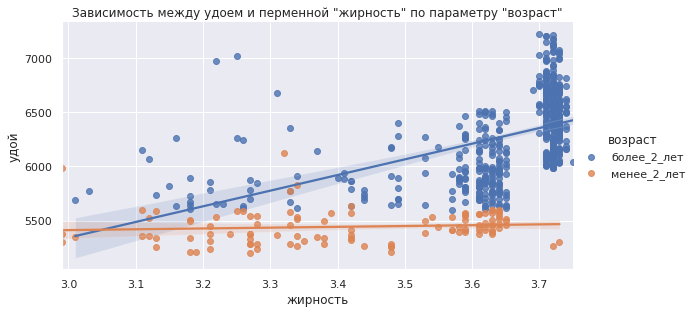

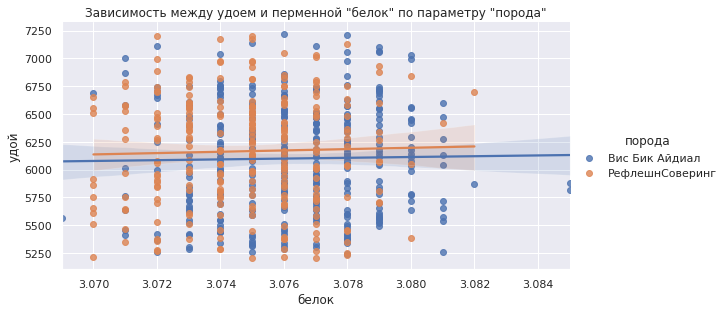

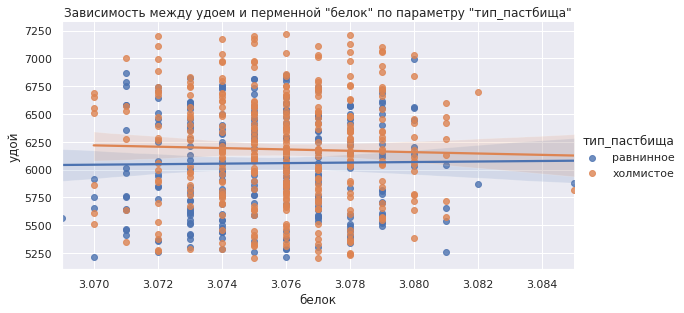

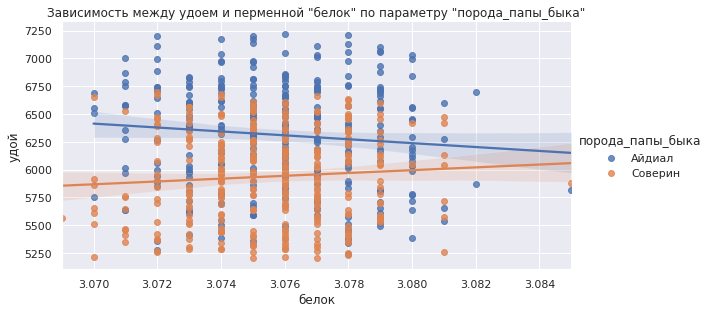

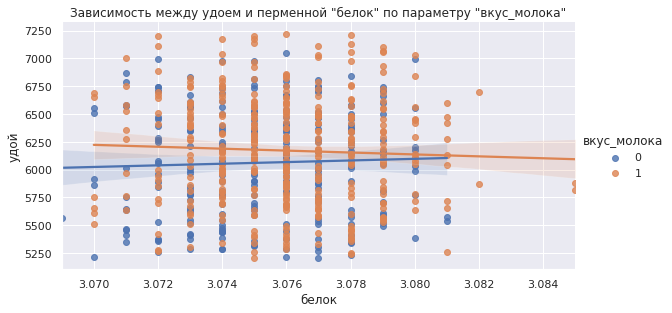

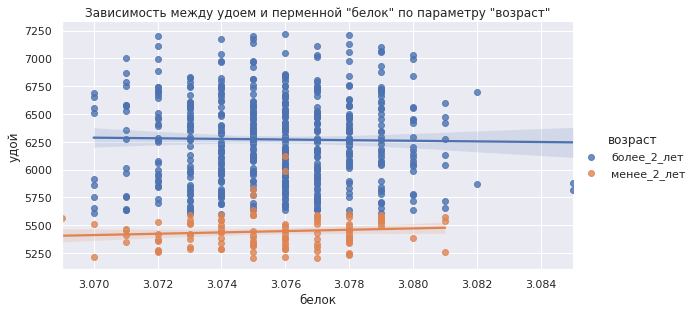

In [47]:
for num_col in ferma_num_cols.drop(['идентификатор_коровы', 'удой']):
    for obj_col in ferma_obj_cols:     
        sns.lmplot(data=ferma_main_data, x=num_col, y='удой', hue=obj_col, height=4, aspect=2)
        plt.title(f'Зависимость между удоем и перменной "{num_col}" по параметру "{obj_col}"')
        plt.show();

По этим многочисленным графикам можно сделать выводы, что:

- коровы, у которых *порода_папы_быка* Айдиал имеют больший удой, чем Соверин,
- коровы, чей возраст превышает 2 года имеют намного больший удой, чем более молодые коровы,
- остальные параметры неявно или очень слабо влияют на удой коровы

**Выводы о взаимосвязи признаков и объёмом удоя**:

- между целевым признаком(удоем) и такими входными количественными признаками, как *энергетическая_кормовая_единица* и *сырой_протеин* линейна, в то время как остальные количественные переменные - *сахаро_протеиновое_соотношение*, *жирность*, *белок* - связаны с удоем нелинейно,
- для проверки неявной зависимости между переменными можно ввести в модель дополнительные признаки,
- категориальные переменные *порода_папы_быка* и *возрас*т также помогают определить *удой* коровы,
- мультиколлинеарность между признаками отсутствует

### Изучение влияния параметров на вкус молока

Как можно увидеть на [тепловой карте](#heatmap), *вкус_молока* слабо зависит от остальных количественных переменных. Однако, хоть все признаки и слабо коррелируют со вкусом молока, хотелось бы выделить, что ,при анализе корреляций переменной *вкус_молока*, *энергетическая_кормовая_единица* влияет на признак больше, чем *сахаро_протеиновое_соотношение*, а значит этот признак предпочтительнее для модели, так как они сильно коррелируют между собой

Посмотрим на зависимость параметра *вкус_молока* от категориальных переменных

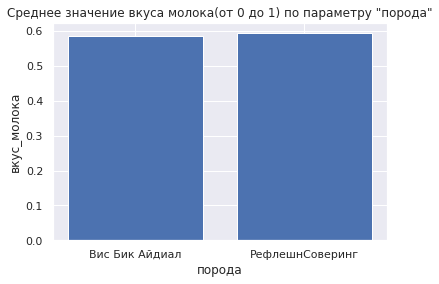

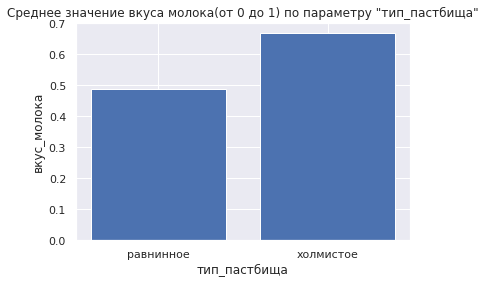

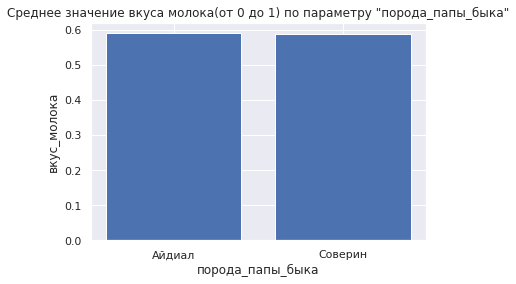

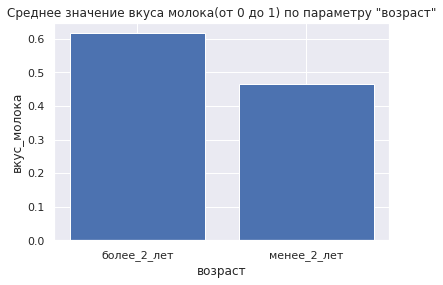

In [48]:
for obj_col in ferma_obj_cols.drop('вкус_молока'):     
    taste_group_data = ferma_main_data.groupby(obj_col)['вкус_молока'].mean()
    
    plt.bar(taste_group_data.index, taste_group_data)
    
    plt.xlabel(obj_col)
    plt.ylabel('вкус_молока')
    plt.title(f'Среднее значение вкуса молока(от 0 до 1) по параметру "{obj_col}"')
    plt.show()


Как видно на этих графиках, на вкус молока влияют *тип_пастбища* и *возраст*, так как среднее значения вкуса молока в этих признаках меняется в зависимости от значения

**Выводы о связи признаков и вкусе молока**:

- *вкус_молока* слабо зависит от остальных количественных переменных, каждый признак имеет слабую корреляцию со вкусом молока,
- на вкус молока влияют категориальные переменные: *тип_пастбища* и *возраст*,
- *энергетическая_кормовая_единица* влияет на признак больше, чем *сахаро_протеиновое_соотношение*, а значит этот признак предпочтительнее для модели, так как они сильно коррелируют между собой

**В результате корреляционного анализа:**

- был изменён тип данных признака вкус_молока на числовой для анализа зависимостей,

**Выводы о взаимосвязи признаков и объёмом удоя**:

- между целевым признаком(удоем) и такими входными количественными признаками, как *энергетическая_кормовая_единица* и *сырой_протеин* линейна, в то время как остальные количественные переменные - *сахаро_протеиновое_соотношение*, *жирность*, *белок* - связаны с удоем нелинейно,
- для проверки неявной зависимости между переменными можно ввести в модель дополнительные признаки,
- категориальные переменные *порода_папы_быка* и *возрас*т также помогают определить *удой* коровы,
- мультиколлинеарность между признаками отсутствует

**Выводы о связи признаков и вкусе молока**:

- *вкус_молока* слабо зависит от остальных количественных переменных, каждый признак имеет слабую корреляцию со вкусом молока,
- на вкус молока влияют категориальные переменные: *тип_пастбища* и *возраст*,
- *энергетическая_кормовая_единица* влияет на признак больше, чем *сахаро_протеиновое_соотношение*, а значит этот признак предпочтительнее для модели, так как они сильно коррелируют между собой

<a id="shag5"></a> 
## Обучение модели линейной регрессии

Постараемся предсказать объём удоя коров с помощью моделей линейной регрессии

In [49]:
ferma_main_data.head()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет


В качестве целевой переменной будет выступать *удой*;

Входными признаками будут:

- *сахаро_протеиновое_соотношение* (имеет самую большую корреляцию с удоем),
- *энергетическая_кормовая_единица* (имеет вторую по величине корреляцию с удоем),
- *жирность* (имеет среднюю корреляцию с целевым признаком),
- *сырой_протеин* (слабо влияет на целевую переменную, однако является относительно независимым признаком),
- *порода_папы_быка* (также влияет на удой и является независимой переменной),
- *возраст* (имеет корреляцию с удоем и не зависит от других параметров)

Таким образом, в датасете будут 3 признака, говорящих о качестве корма(*сахаро_протеиновое_соотношение*, *энергетическая_кормовая_единица*, *сырой_протеин*), 1 признак, характеризующий молоко(*жирность*), и 2 характеристики самой коровы(*порода_папы_быка*, *возраст*)

In [50]:
enter_variables = ['сахаро_протеиновое_соотношение', 'энергетическая_кормовая_единица', 'жирность', 'сырой_протеин',
                   'порода_папы_быка', 'возраст']

X = ferma_main_data[enter_variables]
y = ferma_main_data['удой']

Подготовим тренировочный и тестовый наборы данных

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Закодируем категориальные признаки с помощью OneHotEncoder

In [52]:
encoder = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables = ['порода_папы_быка', 'возраст']

X_train_ohe = encoder.fit_transform(X_train[enter_cat_variables])
X_test_ohe = encoder.transform(X_test[enter_cat_variables])
encoder_col_names = encoder.get_feature_names()

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

Отмасштабируем количественные признаки с помощью StandardScaler

In [53]:
scaler = StandardScaler()

# количественные входные признаки
enter_num_variables = ['сахаро_протеиновое_соотношение', 'энергетическая_кормовая_единица', 'жирность', 'сырой_протеин']

X_train_scaled = scaler.fit_transform(X_train[enter_num_variables])
X_test_scaled = scaler.transform(X_test[enter_num_variables])


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=enter_num_variables)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=enter_num_variables)

In [54]:
X_train_p = pd.concat([X_train_scaled_df, X_train_ohe_df], axis=1)
X_test_p = pd.concat([X_test_scaled_df, X_test_ohe_df], axis=1)

### Первая модель линейной регрессии

Обучим модель линейной регрессии на подготовленных данных

In [55]:
model_lr1 = LinearRegression()

model_lr1.fit(X_train_p, y_train)

LinearRegression()

Предскажем значений тестовой выборки и оценим качество модели

In [56]:
predictions = model_lr1.predict(X_test_p)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print("R2 LinearRegression =", r2)
print("MAE LinearRegression =", mae)

R2 LinearRegression = 0.7800561499002039
MAE LinearRegression = 165.2269079409171


Значение R2 говорит нам о том, что в 78% случаев модель предсказала значения ближе к истине, чем среднее значение целевого признака, что является неплохим результатом

Средняя абсолютная ошибка(MAE) оказалась равна 165, что означает, что в среднем модель ошибается на 165 единицы при определении удоя. Я считаю, что ошибка в 165 единицы при среднем объёме удоя в 6188 является хорошим результатом для модели линейной регрессии

Произведём анализ остатков

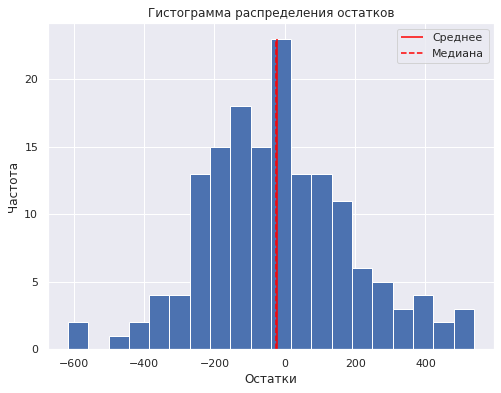

In [57]:
plt.figure(figsize=(8, 6))

residuals = y_test - predictions
bins = plt.hist(residuals, bins=20)

plt.vlines(x=residuals.mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=residuals.median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')

plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма распределения остатков')
plt.legend()
plt.show();

На графике видно бимодальное распределение без смещений

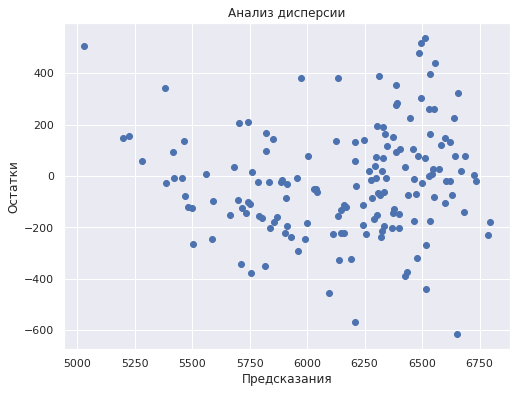

Средний остаток: -21.9484988627646


In [58]:
plt.figure(figsize=(8, 6))

plt.scatter(predictions, residuals)

plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('Анализ дисперсии')
plt.show();

print(f'Средний остаток: {residuals.mean()}')

Анализ дисперсии выявил увеличение разброса ошибки при предсказании большого удоя

**Что можно сделать для улучшения модели:**

- Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не была учтена какая-то информация,

- Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

### Вторая модель линейной регрессии

Исключим нелинейность связи между входными и целевыми признаками

Так, *сахаро_протеиновое_соотношение* и *удой* образуют [два кластера](#corrs), а не линейную связь, по которым можно определить, что *удой* будет превышать 6000 единиц

Преобразуем *сахаро_протеиновое_соотношение* в категориальный признак, чтобы устранить нелинейность("1" - *сахаро_протеиновое_соотношение* > 0.92, "0" - *сахаро_протеиновое_соотношение* <= 0.92)

In [59]:
# функция, которая задает переменной *сахаро_протеиновое_соотношение* 1, если
# значение больше порога для получения удоя в 6000
def set_spo_cat(spo):
    return 1 if spo > 0.92 else 0

In [60]:
ferma_main_data['сахаро_протеиновое_соотношение'] = ferma_main_data['сахаро_протеиновое_соотношение'].apply(set_spo_cat)

Построим новую модель с изменённым признаком

In [61]:
X2 = ferma_main_data.drop('удой', axis=1)
y2 = ferma_main_data['удой']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)

encoder2 = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables2 = ['порода_папы_быка', 'возраст', 'сахаро_протеиновое_соотношение']

X_train_ohe2 = encoder2.fit_transform(X_train2[enter_cat_variables2])
X_test_ohe2 = encoder2.transform(X_test2[enter_cat_variables2])
encoder_col_names2 = encoder2.get_feature_names()

X_train_ohe_df2 = pd.DataFrame(X_train_ohe2, columns=encoder_col_names2)
X_test_ohe_df2 = pd.DataFrame(X_test_ohe2, columns=encoder_col_names2)

scaler2 = StandardScaler()

# количественные входные признаки
enter_num_variables2 = ['жирность', 'сырой_протеин', 'энергетическая_кормовая_единица']

X_train_scaled2= scaler2.fit_transform(X_train2[enter_num_variables2])
X_test_scaled2 = scaler2.transform(X_test2[enter_num_variables2])


X_train_scaled_df2 = pd.DataFrame(X_train_scaled2, columns=enter_num_variables2)
X_test_scaled_df2 = pd.DataFrame(X_test_scaled2, columns=enter_num_variables2)

X_train_p2 = pd.concat([X_train_scaled_df2, X_train_ohe_df2], axis=1)
X_test_p2 = pd.concat([X_test_scaled_df2, X_test_ohe_df2], axis=1)

model_lr2 = LinearRegression()

model_lr2.fit(X_train_p2, y_train2)

predictions2 = model_lr2.predict(X_test_p2)

r2 = r2_score(y_test2, predictions2)
mae = mean_absolute_error(y_test2, predictions2)
print("R2 LinearRegression =", r2)
print("MAE LinearRegression =", mae)

R2 LinearRegression = 0.8138134064861171
MAE LinearRegression = 150.7456086327898


Подготовка данных положительно повлияла на результаты модели: на 3% возрасла точность, а также средняя ошибка уменьшилась на 15 единиц

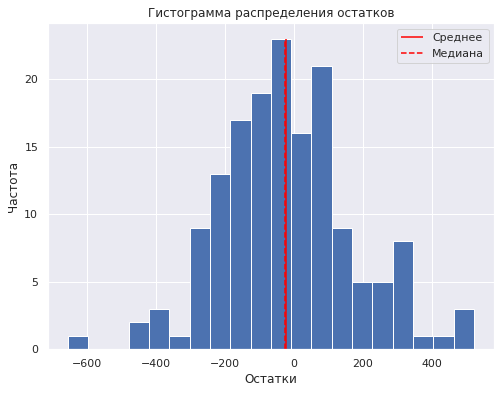

In [62]:
plt.figure(figsize=(8, 6))

residuals2 = y_test2 - predictions2
bins = plt.hist(residuals2, bins=20)

plt.vlines(x=residuals.mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=residuals.median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')

plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма распределения остатков')
plt.legend()
plt.show();

Кроме того, улучшилось распределение остатков - бимодальность стала менее заметной

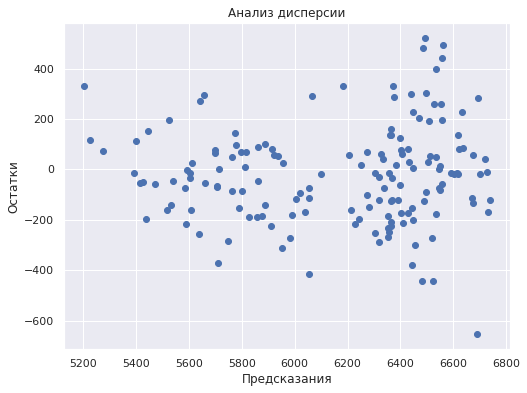

Средний остаток: -20.655465633816085


In [63]:
plt.figure(figsize=(8, 6))

plt.scatter(predictions2, residuals2)

plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('Анализ дисперсии')
plt.show();

print(f'Средний остаток: {residuals2.mean()}')

Однако дисперсия всё также непредсказуема, несмотря на то, что произошло её снижение

**Выводы по качеству второй модели относительно первой:**

- точность предсказаний возросла(на 3%),
- средняя ошибка уменьшилась(на 15 единиц),
- было получено более равномерное распределение остатков более далёкое от бимодального

### Третяя модель линейной регрессии

Обучим новую модель на объединённых данных из **ferma_main_data** и **ferma_dad_data**

In [64]:
ferma_main_data = pd.merge(ferma_main_data, ferma_dad_data, on='идентификатор_коровы')

In [65]:
X3 = ferma_main_data.drop('удой', axis=1)
y3 = ferma_main_data['удой']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42)

encoder3 = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables3 = ['порода_папы_быка', 'возраст', 'сахаро_протеиновое_соотношение', 'имя_папы']

X_train_ohe3 = encoder3.fit_transform(X_train3[enter_cat_variables3])
X_test_ohe3 = encoder3.transform(X_test3[enter_cat_variables3])
encoder_col_names3 = encoder3.get_feature_names()

X_train_ohe_df3 = pd.DataFrame(X_train_ohe3, columns=encoder_col_names3)
X_test_ohe_df3 = pd.DataFrame(X_test_ohe3, columns=encoder_col_names3)

scaler3 = StandardScaler()

# количественные входные признаки
enter_num_variables3 = ['жирность', 'сырой_протеин', 'энергетическая_кормовая_единица']

X_train_scaled3= scaler3.fit_transform(X_train3[enter_num_variables3])
X_test_scaled3 = scaler3.transform(X_test3[enter_num_variables3])


X_train_scaled_df3 = pd.DataFrame(X_train_scaled3, columns=enter_num_variables3)
X_test_scaled_df3 = pd.DataFrame(X_test_scaled3, columns=enter_num_variables3)

X_train_p3 = pd.concat([X_train_scaled_df3, X_train_ohe_df3], axis=1)
X_test_p3 = pd.concat([X_test_scaled_df3, X_test_ohe_df3], axis=1)

model_lr3 = LinearRegression()

model_lr3.fit(X_train_p3, y_train3)

predictions3 = model_lr3.predict(X_test_p3)

r2 = r2_score(y_test3, predictions3)
mae = mean_absolute_error(y_test3, predictions3)
print("R2 LinearRegression =", r2)
print("MAE LinearRegression =", mae)

R2 LinearRegression = 0.8154195593122634
MAE LinearRegression = 151.01663363434525


Точность модели немного возрасла, но средняя ошибка увеличилась на единицу. Таким образом, добавление нового признака является спорным действием

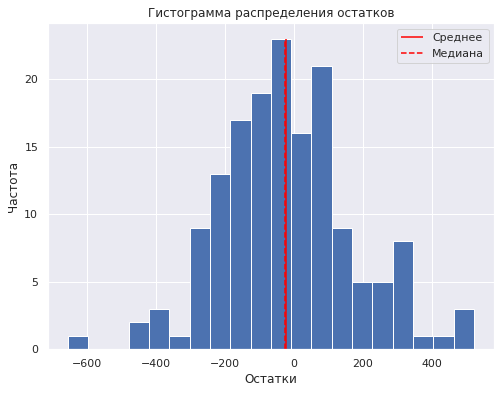

In [66]:
plt.figure(figsize=(8, 6))

residuals3 = y_test3 - predictions3
bins = plt.hist(residuals2, bins=20)

plt.vlines(x=residuals.mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=residuals.median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')

plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма распределения остатков')
plt.legend()
plt.show();

Распределение остатков никак не изменилось(по сравнению со второй моделью)

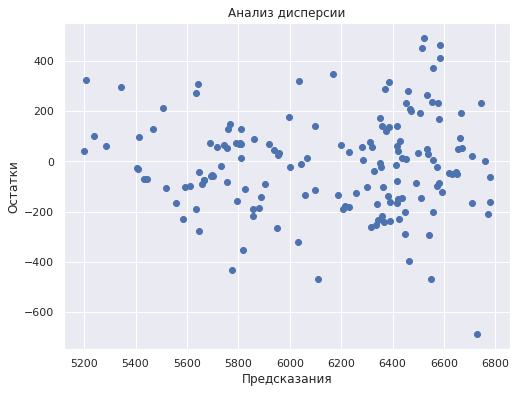

Средний остаток: -12.045483388267684


In [67]:
plt.figure(figsize=(8, 6))

plt.scatter(predictions3, residuals3)

plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('Анализ дисперсии')
plt.show();

print(f'Средний остаток: {residuals3.mean()}')

Дисперсия слабо изменилась, однако средний остаток приблизился к нулю, что говорит нам о положительном влиянии на модель добавленного признака

**Выводы по качеству третьей модели относительно второй:**

- точность предсказаний немного возросла(на 0.5%),
- средняя ошибка увеличилась(на 1),
- распределение остатков слабо изменилась,
- средний остаток значительно уменьшился

### Выбор лучшей модели

Сравним модели по трём метрикам: MSE, MAE, RMSE

In [68]:
print('Модель 1:')
print('R2:', r2_score(y_test, predictions))
print('MAE:', mean_absolute_error(y_test, predictions))
print('RMSE:', mean_squared_error(y_test, predictions)**0.5)

Модель 1:
R2: 0.7800561499002039
MAE: 165.2269079409171
RMSE: 211.59598776420782


In [69]:
print('Модель 2:')
print('R2:', r2_score(y_test2, predictions2))
print('MAE:', mean_absolute_error(y_test2, predictions2))
print('RMSE:', mean_squared_error(y_test2, predictions2)**0.5)

Модель 2:
R2: 0.8138134064861171
MAE: 150.7456086327898
RMSE: 194.68196449421774


In [70]:
print('Модель 3:')
print('R2:', r2_score(y_test3, predictions3))
print('MAE:', mean_absolute_error(y_test3, predictions3))
print('RMSE:', mean_squared_error(y_test3, predictions3)**0.5)

Модель 3:
R2: 0.8154195593122634
MAE: 151.01663363434525
RMSE: 193.8404262693653


Третяя модель является фаворитом по всем показателям, кроме средней ошибки, однако я уверен, что эта модель всё же лучшая, так как возрастание средней ошибки на единицу не так значимо как увеличение точности на полпроцента и уменьшение среднего остатка.

Найдём доверительный интервал прогноза лучшей модели

In [71]:
lower_quantile = np.percentile(residuals3, 2.5)
upper_quantile = np.percentile(residuals3, 97.5)

In [72]:
lower_quantile

-402.7197505369032

In [73]:
upper_quantile

376.55381094844654

Таким образом, 95%-ый доверительный интервал модели находится на промежутке (-402, 376)

### Прогноз удоя покупаемых коров

In [112]:
cow_buy_data

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,сахаро_протеиновое_соотношение,сырой_протеин,энергетическая_кормовая_единица
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.618631,2019.947532,15.276162
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.618631,2019.947532,15.276162
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.618631,2019.947532,15.276162
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.618631,2019.947532,15.276162
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.618631,2019.947532,15.276162
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.618631,2019.947532,15.276162
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.618631,2019.947532,15.276162
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.618631,2019.947532,15.276162
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.618631,2019.947532,15.276162
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.618631,2019.947532,15.276162


Как видим, в датасете не хватает параметров, которые были использованы при обучении модели, так что добавим недостающие признаки, взяв за значения среднее признаков, умноженное на 1.05

Мы можем так сделать, так как знаем, в каких условиях фермер выращивает своих коров

In [75]:
cow_buy_data[['сахаро_протеиновое_соотношение', 'сырой_протеин', 'энергетическая_кормовая_единица']] = ferma_main_data[
    ['сахаро_протеиновое_соотношение', 'сырой_протеин', 'энергетическая_кормовая_единица']].mean() * 1.05

In [136]:
encoder4 = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables4 = ['порода_папы_быка', 'возраст', 'сахаро_протеиновое_соотношение', 'имя_папы']

cow_buy_data_cat = encoder4.fit_transform(cow_buy_data[enter_cat_variables4])
encoder_col_names4 = encoder4.get_feature_names()

cow_buy_data_cat = pd.DataFrame(cow_buy_data_cat, columns=encoder_col_names4)

scaler4 = StandardScaler()

# количественные входные признаки
enter_num_variables4 = ['жирность', 'сырой_протеин', 'энергетическая_кормовая_единица']

cow_buy_data_num = scaler4.fit_transform(cow_buy_data[enter_num_variables4])

cow_buy_data_num = pd.DataFrame(cow_buy_data_num, columns=enter_num_variables4)

cow_buy_data_mo = pd.concat([cow_buy_data_num,
                             pd.DataFrame(cow_buy_data
                                          .reset_index()
                                          .rename(
                                          {'сахаро_протеиновое_соотношение': 'x2_1'},
                                          axis=1)
                                          ['x2_1']),
                             cow_buy_data_cat], axis=1)

predictions4 = model_lr3.predict(cow_buy_data_mo)

Подготовим таблицу на основе данных о покупаемых коровах, в которой будет показан их предполагаемый удой

In [79]:
cow_buy_data_v = cow_buy_data.copy()
cow_buy_data_v['удой'] = predictions4
cow_buy_data_v

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,сахаро_протеиновое_соотношение,сырой_протеин,энергетическая_кормовая_единица,удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.618631,2019.947532,15.276162,6132.491591
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.618631,2019.947532,15.276162,6275.064050
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.618631,2019.947532,15.276162,5654.406392
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.618631,2019.947532,15.276162,6080.123248
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.618631,2019.947532,15.276162,6131.345751
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.618631,2019.947532,15.276162,6308.223956
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.618631,2019.947532,15.276162,5936.525253
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.618631,2019.947532,15.276162,6425.064857
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.618631,2019.947532,15.276162,5693.326533
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.618631,2019.947532,15.276162,5984.625055


In [137]:
cow_buy_data_v[cow_buy_data_v['удой'] > 6000].index

Int64Index([0, 1, 3, 4, 5, 9, 12, 15, 17], dtype='int64')

Таким образом, по критерию удоя фермеру подходят коровы, индекс которых находится в данном списке: (0, 1, 3, 4, 5, 9, 12, 15, 17) - их удой превышеает 6000 единиц

**В ходе процесса обучения моделей линейной регрессии:**

- было проанализировано три модели линейной регрессии,
- была выбрана лучшая модель, способная довольно точно (81% верных предсказаний) предсказать удой коровы,
- был определён объём удоя каждой особи из данных о покупаемых коровах,
- была подготовлена таблица **cow_buy_data_v**, содержащая предполагаемый удой покупаемых коров,
- были выделены коровы, подходящие под критерий удоя фермера. Их индексы в таблице **cow_buy_data_v**: (0, 1, 3, 4, 5, 9, 12, 15, 17)

<a id="shag6"></a> 
## Обучение модели логистической регрессии

In [81]:
ferma_main_data.head()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,Барин


Одним из критериев выбора коров был хороший вкус молока. Спрогнозируем вкус с помощью модели логистической регрессии

### Подготовка данных для модели логистической регрессии и её построение

В качестве целевой переменной модели будет выступать *вкус_молока*

А, основываясь на корреляционном анализе вкуса молока, входными признаками будут:

- энергетическая_кормовая_единица,
- сахаро_протеиновое_соотношение,
- сырой_протеин, 
- тип_пастбища,
- жирность,
- белок,
- возраст,


In [82]:
ferma_main_data.head()

,идентификатор_коровы,удой,энергетическая_кормовая_единица,сырой_протеин,сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,Барин


Подготовим тренировочные и тестовые наборы данных для будущей модели логистической регрессии

In [83]:
enter_variables5 = ['энергетическая_кормовая_единица', 'сахаро_протеиновое_соотношение', 'сырой_протеин',
                   'тип_пастбища', 'жирность', 'белок', 'возраст']

X5 = ferma_main_data[enter_variables5]
y5 = ferma_main_data['вкус_молока']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, random_state=42)

Закодируем категориальные признаки с помощью OneHotEncoder и отмасшатбируем количественные признаки с помощью StandardScaler

In [109]:
encoder5 = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables5 = ['тип_пастбища', 'возраст', 'сахаро_протеиновое_соотношение']

X_train_ohe5 = encoder5.fit_transform(X_train5[enter_cat_variables5])
X_test_ohe5 = encoder5.transform(X_test5[enter_cat_variables5])
encoder_col_names5 = encoder5.get_feature_names()

X_train_ohe_df5 = pd.DataFrame(X_train_ohe5, columns=encoder_col_names5)
X_test_ohe_df5 = pd.DataFrame(X_test_ohe5, columns=encoder_col_names5)

scaler5 = StandardScaler()

# количественные входные признаки
enter_num_variables5 = ['энергетическая_кормовая_единица', 'жирность', 'сырой_протеин', 'белок']

X_train_scaled5= scaler5.fit_transform(X_train5[enter_num_variables5])
X_test_scaled5 = scaler5.transform(X_test5[enter_num_variables5])


X_train_scaled_df5 = pd.DataFrame(X_train_scaled5, columns=enter_num_variables5)
X_test_scaled_df5 = pd.DataFrame(X_test_scaled5, columns=enter_num_variables5)

X_train_p5 = pd.concat([X_train_scaled_df5, X_train_ohe_df5], axis=1)
X_test_p5 = pd.concat([X_test_scaled_df5, X_test_ohe_df5], axis=1)

In [110]:
X_train_p5

,энергетическая_кормовая_единица,жирность,сырой_протеин,белок,x0_холмистое,x1_менее_2_лет,x2_1
0,1.502378,0.562532,1.079523,-0.679069,1.0,0.0,1.0
1,-1.557270,-1.601817,-0.196920,-1.452568,1.0,1.0,0.0
2,0.125537,-2.563750,-1.386085,1.254677,0.0,0.0,0.0
3,-0.103937,0.081565,0.752230,1.254677,1.0,0.0,1.0
4,-1.098323,0.201807,0.828598,0.094429,0.0,0.0,0.0
...,...,...,...,...,...,...,...
466,-0.639376,0.021444,1.565008,0.481179,1.0,0.0,0.0
467,0.278519,0.682773,-0.998788,-1.065819,0.0,0.0,1.0
468,-0.868849,0.141686,-0.818777,-1.839317,0.0,0.0,0.0
469,-1.098323,0.021444,0.130373,-0.292320,0.0,0.0,0.0


Cоздадим модель и обучим её

In [85]:
clf_model = LogisticRegression()
clf_model.fit(X_train_p5, y_train5)

LogisticRegression()

Предскажем значения на тестовой выборке

In [86]:
predictions5 = clf_model.predict(X_test_p5)

### Анализ модели и её настройка

Оценим модель, рассчитав метрики accuracy, recall, precision

In [87]:
print('Accuracy:', accuracy_score(y_test5, predictions5))
print('Precision:', precision_score(y_test5, predictions5))
print('Recall:', recall_score(y_test5, predictions5))

Accuracy: 0.6369426751592356
Precision: 0.628099173553719
Recall: 0.8636363636363636


Метрики говорят нам о том, что модель слишком часто ошибается, присваивая корове класс 1(вкусное) вместо 0(не вкусное), однако большинство коров, класс которых был равен 1, был определён моделью верно

Для наглядности посмотрим на confusion_matrix

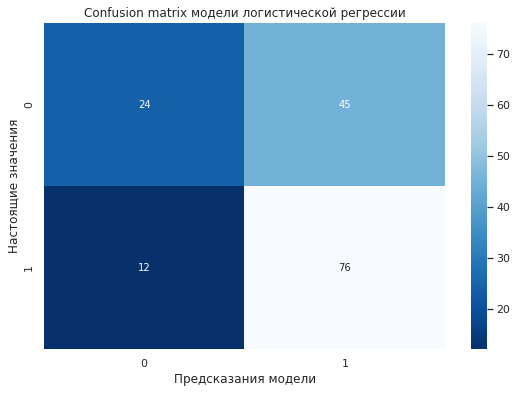

In [88]:
plt.figure(figsize=(9, 6))
cm = confusion_matrix(y_test5, predictions5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Confusion matrix модели логистической регрессии')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказания модели'); 

Заказчик говорил, что купит только тех коров, которые дают вкусное молоко, то есть нам нужна точная модель, которая всегда будет правильно предсказывать, какая корова дает вкусное молоко(то есть мы должны уменьшить количество ошибок первого порядка), несмотря на то, что некоторые коровы, чьё молоко на самом деле вкусное, могут быть определены моделью как коровы, дающие невкусное молоко(то есть мы увеличим количество ошибок второго порядка).
Таким образом, ключевую роль для нас будет играть precision, а не recall

Для этого нам следует изменить порог классификации

Отберём порог классификации, который поможет увеличить precision модели

In [89]:
# находим вероятность правильного ответа
y_pred = clf_model.predict_proba(X_test_p5)[:,1]

threshold_data = pd.DataFrame(zip(y_test5, y_pred),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

# генерируем пороги
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 20,endpoint=False)]

columns = []
overall = []
tn = []
fn = []
fp = []
tp = []

# добавляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    threshold_data['y_pred_'] = threshold_data['y_proba'].apply(lambda x: 1 if x>= i else 0)
    threshold_data['TN'] = threshold_data.apply(lambda x: 1 if x.y_pred_ == 0 and x.y_valid == 0 else 0, 1)
    threshold_data['FN'] = threshold_data.apply(lambda x: 1 if x.y_pred_ == 1 and x.y_valid == 0 else 0, 1)
    threshold_data['FP'] = threshold_data.apply(lambda x: 1 if x.y_pred_ == 0 and x.y_valid == 1 else 0, 1)
    threshold_data['TP'] = threshold_data.apply(lambda x: 1 if x.y_pred_ == 1 and x.y_valid == 1 else 0, 1)
    tn.append(threshold_data['TN'].sum())
    fn.append(threshold_data['FN'].sum())
    fp.append(threshold_data['FP'].sum())
    tp.append(threshold_data['TP'].sum())

pd.DataFrame(zip(columns, tn, fn, fp, tp),columns = ['Порог', 'TN', 'FN', 'FP', 'TP']) 

,Порог,TN,FN,FP,TP
0,y_pred_0.1,0,69,0,88
1,y_pred_0.15,0,69,0,88
2,y_pred_0.19,0,69,0,88
3,y_pred_0.24,1,68,0,88
4,y_pred_0.28,1,68,0,88
5,y_pred_0.32,5,64,1,87
6,y_pred_0.37,7,62,5,83
7,y_pred_0.42,10,59,9,79
8,y_pred_0.46,18,51,11,77
9,y_pred_0.5,24,45,12,76


По данной таблице видно, что при пороге 0.82 модель в 100% cлучаев правильно определяет коров, дающих вкусное молоко, однако сколько такая корова оказалась только одна(TP = 1) - модель слишком сконцентрирована на точности предсказания, а значит нужно понизить порог. Так, если порог будет равен 0.64, то мы получим хороший баланс между точностью предсказаний модели и её полнотой (на одну неправильно предсказанную корову, дающую вкусное молоко, будут преходиться три правильно предсказанные)

Зададим модели новый порог

In [90]:
predictions6 = (y_pred >= 0.64).astype(int)

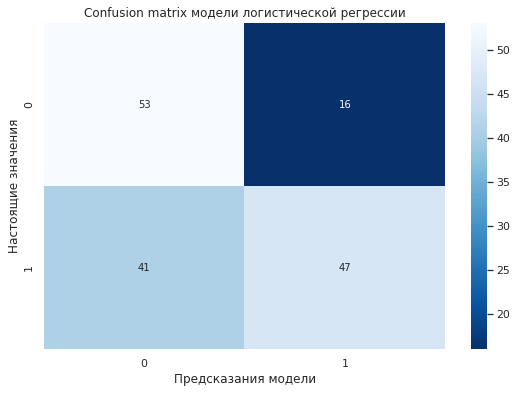

In [91]:
plt.figure(figsize=(9, 6))
cm = confusion_matrix(y_test5, predictions6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Confusion matrix модели логистической регрессии')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказания модели'); 

In [92]:
print('Accuracy:', accuracy_score(y_test5, predictions6))
print('Precision:', precision_score(y_test5, predictions6))
print('Recall:', recall_score(y_test5, predictions6))

Accuracy: 0.6369426751592356
Precision: 0.746031746031746
Recall: 0.5340909090909091


После того, как мы задали порог классификации

- precision модели увеличился на 0.12,
- однако recall упал на 0.33

Так, мы повысили точность модели во вред её полноте - всё для того, чтобы фермер не ошибся с покупкой коровы, дающей вкусное молоко

Можно было бы повысить точность и полноту модели, если было бы побольше значимых признаков или, если бы мы использовали более продвинутый алгоритм МО

### Прогноз вкуса молока

Подготовим данные из таблицы **cow_buy_data** 

In [93]:
cow_buy_data

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,сахаро_протеиновое_соотношение,сырой_протеин,энергетическая_кормовая_единица
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.618631,2019.947532,15.276162
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.618631,2019.947532,15.276162
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.618631,2019.947532,15.276162
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.618631,2019.947532,15.276162
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.618631,2019.947532,15.276162
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.618631,2019.947532,15.276162
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.618631,2019.947532,15.276162
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.618631,2019.947532,15.276162
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,0.618631,2019.947532,15.276162
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.618631,2019.947532,15.276162


In [131]:
encoder7 = OneHotEncoder(sparse=False, drop='first')

# категориальные входные признаки 
enter_cat_variables7 = ['тип_пастбища', 'возраст', 'сахаро_протеиновое_соотношение']

cow_buy_data_cat2 = encoder7.fit_transform(cow_buy_data[enter_cat_variables7])
encoder_col_names7 = encoder7.get_feature_names()

cow_buy_data_cat2 = pd.DataFrame(cow_buy_data_cat2, columns=encoder_col_names7)
scaler7 = StandardScaler()

# количественные входные признаки
enter_num_variables7 = ['энергетическая_кормовая_единица', 'жирность', 'сырой_протеин', 'белок']

cow_buy_data_num2 = scaler7.fit_transform(cow_buy_data[enter_num_variables7])

cow_buy_data_num2 = pd.DataFrame(cow_buy_data_num2, columns=enter_num_variables7)

cow_buy_data_mo2 =  pd.concat([cow_buy_data_num2,
                             pd.DataFrame(cow_buy_data
                                          .reset_index()
                                          .rename(
                                          {'сахаро_протеиновое_соотношение': 'x2_1'},
                                          axis=1)
                                          ['x2_1']),
                             cow_buy_data_cat2], axis=1)
cow_buy_data_mo2
y_pred2 = clf_model.predict_proba(cow_buy_data_mo2)[:,1]

Спрогнозируем *вкус_молока* с помошью модели

In [132]:
predictions7 = (y_pred2 >= 0.64).astype(int)

**В результате обучения модели логистической регрессии**:

- были подготовлены данные для модели логистической регрессии,
- был произведён анализ модели и подбор релевантного порога классификации,
- была получена модель, способная с 74%-ой точностью правильно определить, какая корова даёт вкусное молоко,
- были спрогнозированы данные о вкусе молока коров из таблицы **cow_buy_data**

<a id="shag7"></a> 
## Итоговые выводы

Создадим таблицу, которая будет включать в себя все спрогнозированные данные без добавленных в процессе подготовки данных столбцов

In [133]:
result_data = cow_buy_data_v.copy()
result_data['вкус_молока'] = predictions7
result_data.drop(['сахаро_протеиновое_соотношение', 'сырой_протеин'], axis=1, inplace=True)
result_data

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,энергетическая_кормовая_единица,удой,вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,6132.491591,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,6275.064050,0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,5654.406392,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,6080.123248,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,6131.345751,1
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,6308.223956,0
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,5936.525253,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,6425.064857,0
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,5693.326533,0
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,5984.625055,1


Таким образом, лишь три коровы подходят под критерии фермера(их индексы: 0, 4, 15). Покупая этих коров, фермер может быть уверен, что каждая бурёнка будет давать не менее 6000 килограммов молока в год, а её надой будет вкусным.

Однако, хотелось бы заметить, что в таблице ещё есть 2 коровы(под индексами 7 и 11), удой которых очень близок к 6000, а их молоко вкусное, так что , если фермеру нужно больше коров, то следует рассмотреть эти варианты или расширить выборку данных от «ЭкоФермы»

**Вывод о построенной модели линейной регрессии:**

- для большей точности модели следует избавиться от нелинейной зависимости между входными признаками. Так, при обучении наших моделей линейной регрессии в входных признаках остутствовала переменная *энергетическая_кормовая_единица* из-за большой корреляции с более значимой для удоя переменной *сахаро_протеиновое_соотношение*,
- добавление нового признака из таблицы **ferma_dad_data** также положительно повлияло на точность модели,
- для большей точности в данные могли бы быть добавлены другие признаки также влияющие на удой,
- кроме того, не помешали бы новые данные, которые смогли бы помочь модели лучше понять взаимосвязь между входными и целевыми признаками,
- возможно, другие более сложные модели(у которых можно настраивать гиперпараметры) показали бы себя лучше на данном наборе данных,
- более подробный анализ остатков также мог помочь в улучшении качества модели - так, мы смогли бы понять, где она ошибается и на что стоит обратить внимание(я не знаком с точными алгоритмами анализа остатков. лишь графики и простые метрики)

**Вывод о построенной модели логистической регрессии:**

- здесь также была проведена подготовка данных, в результате которой из-за зависимости между признаками *сахаро_протеиновое_соотношение* и *энергетическая_кормовая_единица* пришлосб выбирать одну переменную(я выбрал вторую из-за большей корреляции с целевой переменной),
- результаты модели сильно зависят от запросов заказчика. Так, для большей точности предсказания коров, дающих вкусное молоко, нам пришлось задать один порог классификации(мы его повысили, тем самым увеличив precsion), однако в другом случае (например, когда нас волнует только общее количество коров, дающих вкусное молоко, и нас не волнует цена ошибки) мы могли бы наоборот снизить порог(повысив recall). Таким образом, логистическая регрессия является очень гибкой моделью, способной менять результаты своей работы в зависимости от ваших целей.
- также, кроме метрик recall, precision и accuracy могут быть использованы F1-меры(позволяющие определить гармонический средний порог между precision и recall) и AUC-ROC(позволяет определить способность модели правильно определять классы)

**В результате загрузки и общего изучения данных:**

- были скачаны таблицы: **ferma_main_data**, **ferma_dad_data**, **cow_buy_data**

В таблице **ferma_main_data**:
- отсутствуют пропущенные значения,
- присутствуют явные дубликаты,
- стобцах *Удой, кг*, *Белок,%* присутствуют аномальные значения,
- типы столбцов не соответсвуют данным

В таблице **ferma_dad_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- отсутствуют явные дубликаты

В таблице **cow_buy_data**:
- отсутствуют пропущенные значения,
- названия параметров не соответствуют стандарту,
- присутствуют явные дубликаты


**В результате предобработки данных были:**

- изменены названия столбцов на таблиц **ferma_main_data, ferma_dad_data, cow_buy_data** на корректные,
- установлено отсутствие неявных дубликатов во всех трёх таблицах


**В ходе исследовательского анализа данных:**

- количественные показатели коров фермера и коров «ЭкоФермы» совпадают,
- были устранены некоторые аномальные значения в количественных параметрах,
- было обнаружено, что большинство коров приносит надой, болший, чем требует заказчик(6000)
- было замечено распределение, далёкое от нормального в столбцах *сахаро_протеиновое_соотношение*(которое связано с отсутствием промежуточных значений) и *белок*(установить причину не удалось)
- коров *Вис Бик Айдиал* больше, чем РефлешнСоверинг,
- в холмистой местности посётся немного больше коров, чем на равнинах,
- породы папы быка распределены равномерно,
- большинство коров даёт вкусное молоко,
- коров, чей возраст превышает 2 года значительно больше, чем коров младше двух лет


**В результате корреляционного анализа:**

- был изменён тип данных признака вкус_молока на числовой для анализа зависимостей,

**Выводы о взаимосвязи признаков и объёмом удоя**:

- между целевым признаком(удоем) и такими входными количественными признаками, как *энергетическая_кормовая_единица* и *сырой_протеин* линейна, в то время как остальные количественные переменные - *сахаро_протеиновое_соотношение*, *жирность*, *белок* - связаны с удоем нелинейно,
- для проверки неявной зависимости между переменными можно ввести в модель дополнительные признаки,
- категориальные переменные *порода_папы_быка* и *возрас*т также помогают определить *удой* коровы,
- мультиколлинеарность между признаками отсутствует

**Выводы о связи признаков и вкусе молока**:

- *вкус_молока* слабо зависит от остальных количественных переменных, каждый признак имеет слабую корреляцию со вкусом молока,
- на вкус молока влияют категориальные переменные: *тип_пастбища* и *возраст*,
- *энергетическая_кормовая_единица* влияет на признак больше, чем *сахаро_протеиновое_соотношение*, а значит этот признак предпочтительнее для модели, так как они сильно коррелируют между собой


**В ходе процесса обучения моделей линейной регрессии:**

- было проанализировано три модели линейной регрессии,
- была выбрана лучшая модель, способная довольно точно (81% верных предсказаний) предсказать удой коровы,
- был определён объём удоя каждой особи из данных о покупаемых коровах,
- была подготовлена таблица **cow_buy_data_v**, содержащая предполагаемый удой покупаемых коров,
- были выделены коровы, подходящие под критерий удоя фермера. Их индексы в таблице **cow_buy_data_v**: (0, 1, 3, 4, 5, 9, 12, 15, 17)

**В результате обучения модели логистической регрессии**:

- были подготовлены данные для модели логистической регрессии,
- был произведён анализ модели и подбор релевантного порога классификации,
- была получена модель, способная с 74%-ой точностью правильно определить, какая корова даёт вкусное молоко,
- были спрогнозированы данные о вкусе молока коров из таблицы **cow_buy_data**

Таким образом, были определены коровы, подходящие под критерии фермера, даны некоторые рекомендации, сделаны выводы об обученных моделях, а также представлен подробный процесс работы с данными

Данное исследование с последующей разработкой машинного обучения может быть полезно для следующих заказов фермеров